In [1]:
import os

import imageio
import matplotlib.pyplot as plt

from peek_behind import detect_features, match_keypoints_bf, match_keypoints_knn, compute_homography
from poisson import *
cv2.ocl.setUseOpenCL(False)

Demonstration of the image blending algorithm

In [2]:
feature_extractor = 'sift' # one of 'sift', 'surf', 'brisk', 'orb'
feature_matching = 'knn' # one of 'knn', 'bf'

In [3]:
sample_path = "samples/france2"

query_image_path = os.path.join(sample_path, 'source.jpg')
query_mask_path =  os.path.join(sample_path, 'mask.png')
side_image_path = os.path.join(sample_path, 'dest.jpg')

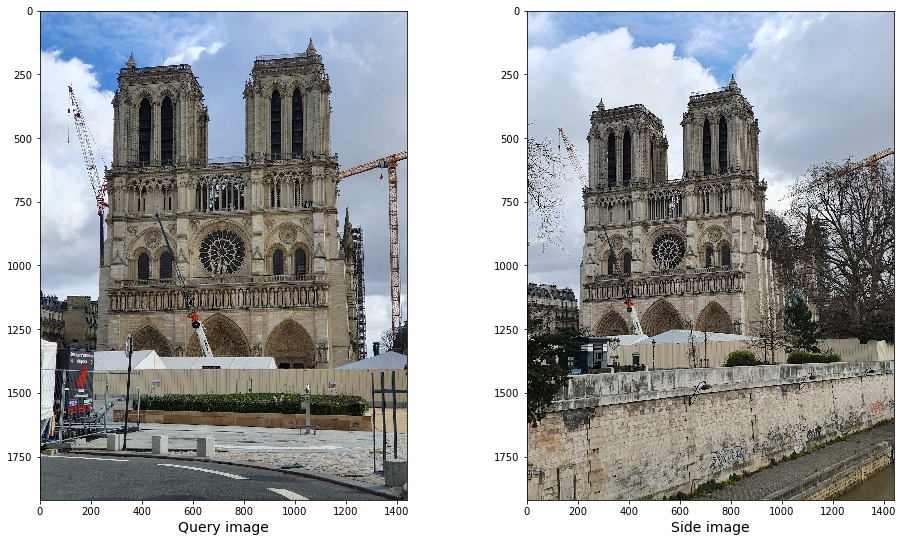

In [4]:
query_mask = cv2.imread(query_mask_path, 0)
query_img = imageio.imread(query_image_path)

side_img = imageio.imread(side_image_path)

side_img_gray = cv2.cvtColor(side_img, cv2.COLOR_RGB2GRAY)
query_img_gray = cv2.cvtColor(query_img, cv2.COLOR_RGB2GRAY)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,9))
ax1.imshow(query_img, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(side_img, cmap="gray")
ax2.set_xlabel("Side image", fontsize=14)

plt.show()

In [5]:
kpsA, featuresA = detect_features(side_img_gray, method=feature_extractor)
kpsB, featuresB = detect_features(query_img_gray, method=feature_extractor)

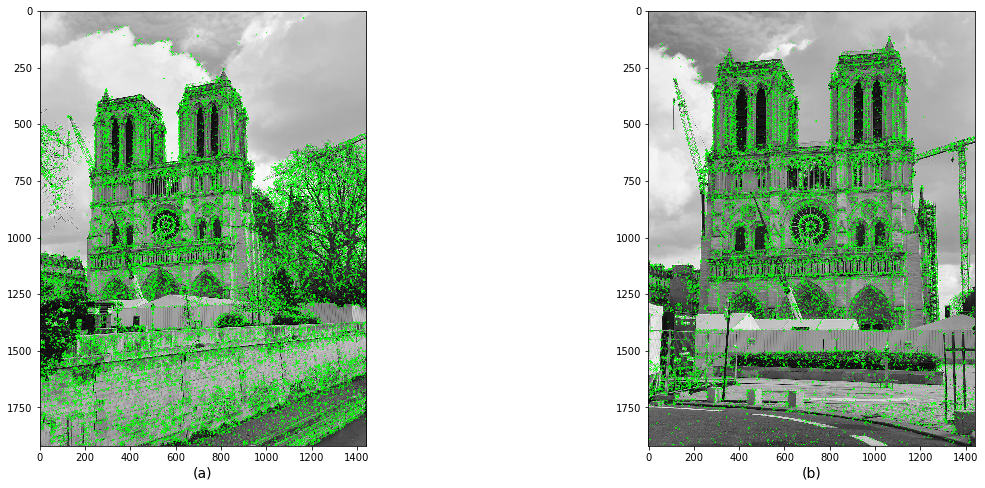

In [6]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
ax1.imshow(cv2.drawKeypoints(side_img_gray,kpsA,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(query_img_gray,kpsB,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

plt.show()

Using: knn feature matcher
Raw matches (knn): 31729


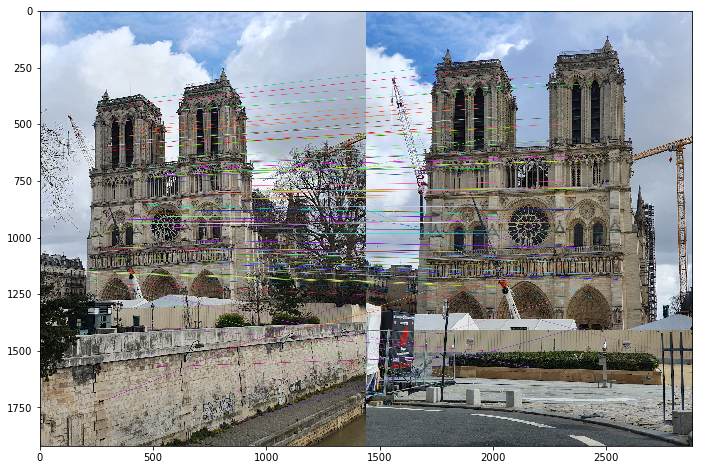

In [7]:
print("Using: {} feature matcher".format(feature_matching))

fig = plt.figure(figsize=(20,8))

if feature_matching == 'bf':
    matches = match_keypoints_bf(featuresA, featuresB, method=feature_extractor)
    matched_keypoints = cv2.drawMatches(side_img,kpsA,query_img,kpsB,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching == 'knn':
    matches = match_keypoints_knn(featuresA, featuresB, ratio=0.80, method=feature_extractor)
    matched_keypoints = cv2.drawMatches(side_img,kpsA,query_img,kpsB,np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

plt.imshow(matched_keypoints)
plt.show()

In [8]:
M = compute_homography(kpsA, kpsB, matches, reprojThresh=4)
(matches, H, status) = M
print(H)

[[ 1.43738922e+00  1.07096997e-03 -5.62070742e+01]
 [ 1.19919263e-01  1.26407581e+00 -3.01170880e+02]
 [ 6.17549425e-05 -2.49968225e-05  1.00000000e+00]]


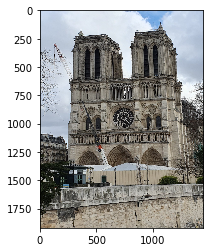

In [9]:
height, width,_ = side_img.shape
side_image_transformed = cv2.warpPerspective(side_img, H, (width, height))

plt.imshow(side_image_transformed)
plt.show()

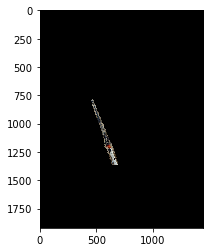

In [10]:
overlapped_part = cv2.bitwise_and(query_img, query_img, mask=query_mask)
plt.imshow(overlapped_part)
plt.show()

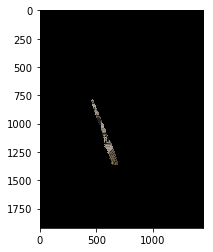

In [11]:
overlapped_part = cv2.bitwise_and(side_image_transformed, side_image_transformed, mask=query_mask)
plt.imshow(overlapped_part)
plt.show()

In [12]:
copy_past_blending = np.zeros((height, width, 3), np.uint8)
for x in range(height):
    for y in range(width):
        if query_mask[x][y] > 0 and np.sum(side_image_transformed[x][y]) > 0:
            copy_past_blending[x][y] = side_image_transformed[x][y]
        else:
            copy_past_blending[x][y] = query_img[x][y]

In [13]:
blending_result = poisson_edit(side_image_transformed, query_img, query_mask, (0,0))

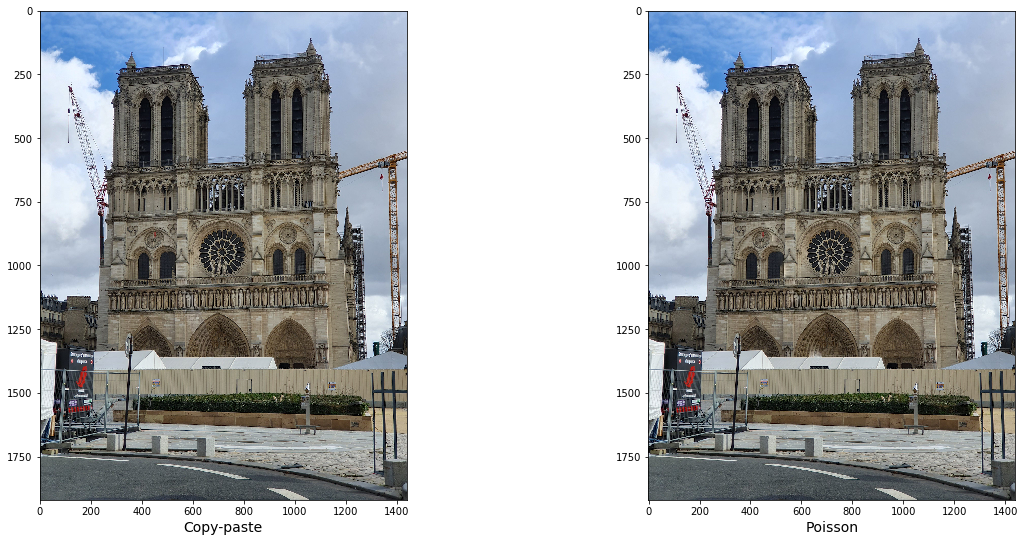

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,9))
ax1.imshow(copy_past_blending, cmap="gray")
ax1.set_xlabel("Copy-paste", fontsize=14)

ax2.imshow(blending_result, cmap="gray")
ax2.set_xlabel("Poisson", fontsize=14)

plt.show()